In [1]:
from hyperband.hyperband import Hyperband
from hyperopt import hp
from xgboost import XGBRegressor as XGB
from hyperopt.pyll.stochastic import sample
import datetime
import pandas as pd
import numpy as np
from pprint import pprint
import json
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
import GPy
import GPyOpt
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from functools import reduce

In [2]:
def load_data():
    dframe_path = 'data/cabauw/processed-full-log.csv.gz'
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

    df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
    df = df[df.ds != 201603]
    
    return df

df = load_data()
wind_temp_levels = df.pivot_table(
    values=['wind', 'temp'], columns='z', index=['ds', 'tt']
).reset_index()
wind_temp_levels.columns = [
    '%s_%d' % (a, b) if b else a
    for a, b in wind_temp_levels.columns.values
]

ddf = df.merge(wind_temp_levels, on=['ds', 'tt']).dropna()
ddf = ddf[(ddf.zL > -2) & (ddf.zL < 1)]


feats = [
    'air_dens', 'wind', 'temp', 'virtual_temp',
    'soil_temp', 'z',
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux',
    'soilheat', 'netrad', 'temp_10', 'temp_20', 'temp_40', 'wind_10',
    'wind_20', 'wind_40'
]

ddf = ddf[feats + ['phi_m', 'ds']].dropna()

create a training set, a validation set, and a test set

we return the score on the validation set to the hyper-parameter tuning framework so that it has an idea of generalization, but eventually test the best hyper-parameters on the test set

In [3]:
len(df.ds.unique())

202

In [4]:
np.random.seed(94825697)

not_train_months = np.random.choice(ddf.ds.unique(), 40, replace=False)
np.random.shuffle(not_train_months)

train_mask = ~ddf.ds.isin(not_train_months)
val_mask = ddf.ds.isin(not_train_months[:20])
test_mask = ddf.ds.isin(not_train_months[20:])

train_x, train_y = ddf[train_mask][feats], ddf[train_mask].phi_m
val_x, val_y = ddf[val_mask][feats], ddf[val_mask].phi_m
test_x, test_y = ddf[test_mask][feats], ddf[test_mask].phi_m

mu_x, std_x = train_x.mean(), train_x.std()
mu_y, std_y = train_y.mean(), train_y.std()

train_x = (train_x - mu_x) / std_x
train_y = (train_y - mu_y) / std_y

val_x = (val_x - mu_x) / std_x
val_y = (val_y - mu_y) / std_y

test_x = (test_x - mu_x) / std_x
test_y = (test_y - mu_y) / std_y

In [80]:
space = {
    'learning_rate': hp.loguniform('ra_', np.log(1e-4), np.log(1)),
    'max_depth': hp.quniform('md_', 1, 15, 1),
    'min_child_weight': hp.quniform('mcw_', 1, 10, 1),
    'subsample': hp.uniform('ss_', 0.1, 1.0),
    'gamma': hp.uniform('g_', 0, 1),
    'reg_alpha': hp.loguniform('ra_', np.log(1e-20), np.log(1)),
    'reg_lambda': hp.loguniform('ra_', np.log(1e-20), np.log(1)),
    'colsample_bytree': hp.uniform('cbt_', 0.1, 1.0),
    'loss': hp.choice('loss', ['rmse', 'mae',]),
}


def handle_integers(params):
    new_params = {}
    for k, v in params.items():
        if type(v) == float and int(v) == v:
            new_params[k] = int(v)
        else:
            new_params[k] = v

    return new_params


def get_params():
    params = sample(space)
    params = {k: v for k, v in params.items() if v is not 'default'}
    return handle_integers(params)


trees_per_iteration = 15
def try_params(n_iterations, params, get_predictions=False):
    params['n_estimators'] = int(round(n_iterations * trees_per_iteration))
    result = fit_score(params, get_predictions=get_predictions)
    return result


def fit_score(params, save=True, get_predictions=False):
    
    def evaluate(model, xx, yy, std_y):
        pred = model.predict(xx)
        mse = np.mean((pred - yy)**2)
        denorm = mse * std_y**2
        return mse, denorm

    try:
        model = XGB(tree_method='gpu_exact', **params)
        model.fit(train_x, train_y)

        train_mse, train_denorm = evaluate(model, train_x, train_y, std_y)
        
        val_mse = val_denorm = np.nan
        if val_x is not None and val_y is not None:
            val_mse, val_denorm = evaluate(model, val_x, val_y, std_y)
        
        test_mse = test_denorm = np.nan
        if test_x is not None and test_y is not None:
            test_mse, test_denorm = evaluate(model, test_x, test_y, std_y)
        
        test_preds = model.predict(test_x) if get_predictions else None
    finally:
        del(model)  # https://github.com/dmlc/xgboost/issues/3045

    result = {
        'train_mse': train_mse,
        'train_denorm': train_denorm,
        
        'val_mse': val_mse,
        'val_denorm': val_denorm,
        
        'test_mse': test_mse,
        'test_denorm': test_denorm,
        
        'params': params,
        'loss': val_denorm,
        
        'test_preds': test_preds,
    }
    
    if save:
        with open('dev/hyperopt.jsonl', 'a') as f:
            f.write(json.dumps(result))
            f.write('\n')
    
    print(result)

    return result

hyper parameters optimization with hyperband



paper https://arxiv.org/pdf/1603.06560.pdf

code https://github.com/zygmuntz/hyperband

In [7]:
hb = Hyperband(get_params, try_params)
hb_res = hb.run()


*** 81 configurations x 1.0 iterations each

1 | Thu May 24 23:42:46 2018 | lowest loss so far: inf (run -1)

{'train_mse': 1.2137144435843825, 'train_denorm': 1.0251139114019305, 'val_mse': 1.1265702827364765, 'val_denorm': 0.9515111854437426, 'test_mse': 1.2134173123171463, 'test_denorm': 1.0248629517160124, 'params': {'colsample_bytree': 0.1607342106696886, 'gamma': 0.9703237454427931, 'learning_rate': 0.001486463795196894, 'loss': 'mae', 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.001533402502544231, 'reg_lambda': 8.095501449015038e-10, 'subsample': 0.9289538790229294, 'n_estimators': 15}, 'loss': 0.9515111854437426}

8 seconds.

2 | Thu May 24 23:42:54 2018 | lowest loss so far: 0.9515 (run 1)

{'train_mse': 0.3861683494075783, 'train_denorm': 0.32616118990208565, 'val_mse': 0.3773546262960723, 'val_denorm': 0.3187170417166469, 'test_mse': 0.3748766032995342, 'test_denorm': 0.3166240816633553, 'params': {'colsample_bytree': 0.537020280414406, 'gamma': 0.2731328699602404

{'train_mse': 1.2152215606857921, 'train_denorm': 1.0263868357828945, 'val_mse': 1.1275098969681225, 'val_denorm': 0.9523047919014255, 'test_mse': 1.2150527707853478, 'test_denorm': 1.026244274346006, 'params': {'colsample_bytree': 0.41867501770235394, 'gamma': 0.6250420983820594, 'learning_rate': 0.0012984463476095462, 'loss': 'mae', 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 3.014439432013692e-17, 'reg_lambda': 0.0006896933572431786, 'subsample': 0.7062220940995952, 'n_estimators': 15}, 'loss': 0.9523047919014255}

7 seconds.

16 | Thu May 24 23:44:37 2018 | lowest loss so far: 0.2094 (run 10)

{'train_mse': 1.205732668864195, 'train_denorm': 1.01837243415694, 'val_mse': 1.1195315909445434, 'val_denorm': 0.9455662443481482, 'test_mse': 1.205460533995054, 'test_denorm': 1.0181425866490614, 'params': {'colsample_bytree': 0.6992739225765362, 'gamma': 0.9990118289884818, 'learning_rate': 0.0018219944063007478, 'loss': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'reg_alpha': 3

{'train_mse': 0.18408663265101302, 'train_denorm': 0.15548119166843416, 'val_mse': 0.2220615241914348, 'val_denorm': 0.18755511960744806, 'test_mse': 0.22455049238652317, 'test_denorm': 0.18965732407185812, 'params': {'colsample_bytree': 0.49896275210867835, 'gamma': 0.0634934264883541, 'learning_rate': 0.4519399177810736, 'loss': 'mae', 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.0004202133356059269, 'reg_lambda': 2.6403136217735165e-08, 'subsample': 0.9829216339243517, 'n_estimators': 15}, 'loss': 0.18755511960744806}

8 seconds.

30 | Thu May 24 23:46:29 2018 | lowest loss so far: 0.1876 (run 29)

{'train_mse': 0.20413916197049656, 'train_denorm': 0.17241773458662718, 'val_mse': 0.22476379760276008, 'val_denorm': 0.18983748353662752, 'test_mse': 0.23437405896892488, 'test_denorm': 0.19795439494914227, 'params': {'colsample_bytree': 0.14970111101566683, 'gamma': 0.01345131312230785, 'learning_rate': 0.5477966866623029, 'loss': 'mae', 'max_depth': 8, 'min_child_weight': 9, '

{'train_mse': 1.2469513940075454, 'train_denorm': 1.0531861325338954, 'val_mse': 1.1558946369633682, 'val_denorm': 0.9762787933598914, 'test_mse': 1.2465507386087287, 'test_denorm': 1.0528477354544372, 'params': {'colsample_bytree': 0.22488957406108828, 'gamma': 0.6013461684648419, 'learning_rate': 0.00012853917826452578, 'loss': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'reg_alpha': 6.102453870538521e-14, 'reg_lambda': 1.649078331068734e-20, 'subsample': 0.5844621643601353, 'n_estimators': 15}, 'loss': 0.9762787933598914}

6 seconds.

44 | Thu May 24 23:48:19 2018 | lowest loss so far: 0.1876 (run 29)

{'train_mse': 1.2437984000119469, 'train_denorm': 1.0505230860285664, 'val_mse': 1.1529834971578725, 'val_denorm': 0.9738200190341642, 'test_mse': 1.2434279641528274, 'test_denorm': 1.0502102126385588, 'params': {'colsample_bytree': 0.3984838689829153, 'gamma': 0.8723021808112381, 'learning_rate': 0.00022020710669582867, 'loss': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'reg_a

{'train_mse': 0.7832498885763804, 'train_denorm': 0.6615397560174435, 'val_mse': 0.7383518635345633, 'val_denorm': 0.6236184885330469, 'test_mse': 0.7957662977261343, 'test_denorm': 0.6721112254500053, 'params': {'colsample_bytree': 0.5509572730090974, 'gamma': 0.5974589068093633, 'learning_rate': 0.019549447185565637, 'loss': 'mae', 'max_depth': 13, 'min_child_weight': 3, 'reg_alpha': 4.353548805096913e-20, 'reg_lambda': 1.4290410480467292e-12, 'subsample': 0.8189756849293668, 'n_estimators': 15}, 'loss': 0.6236184885330469}

11 seconds.

58 | Thu May 24 23:50:03 2018 | lowest loss so far: 0.1876 (run 29)

{'train_mse': 1.237465515515981, 'train_denorm': 1.045174275993033, 'val_mse': 1.1474277218505855, 'val_denorm': 0.9691275622654174, 'test_mse': 1.237598316652883, 'test_denorm': 1.0452864410031864, 'params': {'colsample_bytree': 0.22260823553582354, 'gamma': 0.4895177092346781, 'learning_rate': 0.00039453916486777786, 'loss': 'mae', 'max_depth': 15, 'min_child_weight': 5, 'reg_alph

{'train_mse': 0.12320857560108861, 'train_denorm': 0.1040630483721448, 'val_mse': 0.20902142051265626, 'val_denorm': 0.17654133316212758, 'test_mse': 0.21591940992576403, 'test_denorm': 0.182367435789033, 'params': {'colsample_bytree': 0.8856110241164611, 'gamma': 0.625913717076527, 'learning_rate': 0.1714449186277679, 'loss': 'rmse', 'max_depth': 14, 'min_child_weight': 1, 'reg_alpha': 2.708293649555477e-13, 'reg_lambda': 3.372776145230454e-07, 'subsample': 0.9876981440653535, 'n_estimators': 15}, 'loss': 0.17654133316212758}

11 seconds.

72 | Thu May 24 23:52:01 2018 | lowest loss so far: 0.1765 (run 71)

{'train_mse': 1.2340278184133322, 'train_denorm': 1.042270766735366, 'val_mse': 1.144304542394521, 'val_denorm': 0.9664896973828333, 'test_mse': 1.2337359126271414, 'test_denorm': 1.0420242205367731, 'params': {'colsample_bytree': 0.9728982410204129, 'gamma': 0.0031248849704029746, 'learning_rate': 0.0005901489809212802, 'loss': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'reg_a

{'train_mse': 0.12580830995965395, 'train_denorm': 0.10625880691403417, 'val_mse': 0.29997608420507893, 'val_denorm': 0.2533624433918372, 'test_mse': 0.3858083811822317, 'test_denorm': 0.32585715756777833, 'params': {'colsample_bytree': 0.32819713582772125, 'gamma': 0.09060291997939907, 'learning_rate': 0.49433450155885844, 'loss': 'rmse', 'max_depth': 11, 'min_child_weight': 7, 'reg_alpha': 0.02088811086995745, 'reg_lambda': 1.1546904861100036e-05, 'subsample': 0.5812556215003194, 'n_estimators': 45}, 'loss': 0.2533624433918372}

20 seconds.

86 | Thu May 24 23:54:38 2018 | lowest loss so far: 0.1765 (run 71)

{'train_mse': 0.17060519227346724, 'train_denorm': 0.14409464835933078, 'val_mse': 0.2263047869882843, 'val_denorm': 0.19113901674715633, 'test_mse': 0.2322280196526169, 'test_denorm': 0.19614183123681972, 'params': {'colsample_bytree': 0.14970111101566683, 'gamma': 0.01345131312230785, 'learning_rate': 0.5477966866623029, 'loss': 'mae', 'max_depth': 8, 'min_child_weight': 9, 'r

{'train_mse': 0.29606690412239917, 'train_denorm': 0.25006071545565506, 'val_mse': 0.28535233431024276, 'val_denorm': 0.24101109540112936, 'test_mse': 0.2839047237219545, 'test_denorm': 0.2397884307453768, 'params': {'colsample_bytree': 0.537020280414406, 'gamma': 0.27313286996024044, 'learning_rate': 0.5879073598804128, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 9, 'reg_alpha': 0.0138842118730086, 'reg_lambda': 5.56837161514801e-15, 'subsample': 0.8047419313529135, 'n_estimators': 45}, 'loss': 0.24101109540112936}

6 seconds.

100 | Thu May 24 23:58:23 2018 | lowest loss so far: 0.1669 (run 89)

{'train_mse': 0.280739837700285, 'train_denorm': 0.23711534013006405, 'val_mse': 0.2787670397335347, 'val_denorm': 0.23544909758776664, 'test_mse': 0.2745929947564389, 'test_denorm': 0.2319236624284043, 'params': {'colsample_bytree': 0.1891610405468237, 'gamma': 0.7413393648513519, 'learning_rate': 0.10376172048249986, 'loss': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha':

{'train_mse': 0.11775925012595569, 'train_denorm': 0.09946050006941685, 'val_mse': 0.22823008831906022, 'val_denorm': 0.192765143212283, 'test_mse': 0.23559255820694244, 'test_denorm': 0.19898355014007463, 'params': {'colsample_bytree': 0.49896275210867835, 'gamma': 0.0634934264883541, 'learning_rate': 0.4519399177810736, 'loss': 'mae', 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.0004202133356059269, 'reg_lambda': 2.6403136217735165e-08, 'subsample': 0.9829216339243517, 'n_estimators': 135}, 'loss': 0.192765143212283}

44 seconds.

114 | Fri May 25 00:04:34 2018 | lowest loss so far: 0.1650 (run 111)

{'train_mse': 0.18880663197308886, 'train_denorm': 0.15946774467721134, 'val_mse': 0.20884212964290227, 'val_denorm': 0.1763899025140508, 'test_mse': 0.22103259428605113, 'test_denorm': 0.18668607634489012, 'params': {'colsample_bytree': 0.9097108609129753, 'gamma': 0.7474554078750473, 'learning_rate': 0.4678491696626623, 'loss': 'mae', 'max_depth': 5, 'min_child_weight': 2, 're

{'train_mse': 0.9657522548547235, 'train_denorm': 0.8156828623507522, 'val_mse': 0.9047554278400104, 'val_denorm': 0.7641644048958852, 'test_mse': 0.9759067613608242, 'test_denorm': 0.8242594480030441, 'params': {'colsample_bytree': 0.503067938678082, 'gamma': 0.3287817236651377, 'learning_rate': 0.003453199388730339, 'loss': 'rmse', 'max_depth': 14, 'min_child_weight': 2, 'reg_alpha': 1.9242383854269935e-13, 'reg_lambda': 4.7505882155563076e-11, 'subsample': 0.9504428551203983, 'n_estimators': 45}, 'loss': 0.7641644048958852}

28 seconds.

128 | Fri May 25 00:21:17 2018 | lowest loss so far: 0.1633 (run 118)

{'train_mse': 1.217596623921227, 'train_denorm': 1.028392835114923, 'val_mse': 1.1297659435317686, 'val_denorm': 0.9542102687039707, 'test_mse': 1.2173372238301434, 'test_denorm': 1.0281737435127802, 'params': {'colsample_bytree': 0.3659533138574381, 'gamma': 0.916068734621244, 'learning_rate': 0.0004208745163684774, 'loss': 'mae', 'max_depth': 7, 'min_child_weight': 5, 'reg_alph

{'train_mse': 0.9780366578582007, 'train_denorm': 0.8260583773482851, 'val_mse': 0.9117912772623095, 'val_denorm': 0.7701069453010465, 'test_mse': 0.9824651770094006, 'test_denorm': 0.829798743636914, 'params': {'colsample_bytree': 0.2928652719435396, 'gamma': 0.131301254489528, 'learning_rate': 0.003431591451266153, 'loss': 'mae', 'max_depth': 12, 'min_child_weight': 5, 'reg_alpha': 1.284448899776726e-11, 'reg_lambda': 0.023719649700533744, 'subsample': 0.5462716226443541, 'n_estimators': 45}, 'loss': 0.7701069453010465}

24 seconds.

142 | Fri May 25 00:24:49 2018 | lowest loss so far: 0.1633 (run 118)

{'train_mse': 1.1404957446645825, 'train_denorm': 0.9632727532661056, 'val_mse': 1.0624665059548482, 'val_denorm': 0.8973685708447241, 'test_mse': 1.1405550594979135, 'test_denorm': 0.9633228510968775, 'params': {'colsample_bytree': 0.7267059275005391, 'gamma': 0.29976693555691714, 'learning_rate': 0.0016481293730253453, 'loss': 'mae', 'max_depth': 5, 'min_child_weight': 2, 'reg_alpha

{'train_mse': 0.3013554389098045, 'train_denorm': 0.2545274585270251, 'val_mse': 0.2940524538649226, 'val_denorm': 0.24835929302166979, 'test_mse': 0.289024749166283, 'test_denorm': 0.24411284934108257, 'params': {'colsample_bytree': 0.6486837656222405, 'gamma': 0.246125316640731, 'learning_rate': 0.22924103037491875, 'loss': 'rmse', 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 1.2217622013196578e-15, 'reg_lambda': 4.7914206596107034e-15, 'subsample': 0.6033330919983996, 'n_estimators': 45}, 'loss': 0.24835929302166979}

8 seconds.

*** 11.333333333333332 configurations x 9.0 iterations each

156 | Fri May 25 00:28:15 2018 | lowest loss so far: 0.1633 (run 118)

{'train_mse': 0.1385271592339457, 'train_denorm': 0.1170012590591992, 'val_mse': 0.2039087243023068, 'val_denorm': 0.1722231049020082, 'test_mse': 0.2118025294334972, 'test_denorm': 0.17889028225715403, 'params': {'colsample_bytree': 0.1004858078739882, 'gamma': 0.08652144711055498, 'learning_rate': 0.27797168000512074, 

{'train_mse': 0.15110199861476087, 'train_denorm': 0.12762207917966292, 'val_mse': 0.19223202027771222, 'val_denorm': 0.1623608578156303, 'test_mse': 0.20065646532501963, 'test_denorm': 0.16947621831865914, 'params': {'colsample_bytree': 0.7442617449377118, 'gamma': 0.5719298756873548, 'learning_rate': 0.06562569091074327, 'loss': 'mae', 'max_depth': 8, 'min_child_weight': 10, 'reg_alpha': 6.026835997564143e-17, 'reg_lambda': 1.340361869207591e-07, 'subsample': 0.7973620234060455, 'n_estimators': 405}, 'loss': 0.1623608578156303}

114 seconds.

*** 1.259259259259259 configurations x 81.0 iterations each

170 | Fri May 25 00:41:25 2018 | lowest loss so far: 0.1623 (run 167)

{'train_mse': 0.05681841312252835, 'train_denorm': 0.047989332271332036, 'val_mse': 0.19418273368094313, 'val_denorm': 0.16400844754102292, 'test_mse': 0.2000596073961622, 'test_denorm': 0.16897210685386074, 'params': {'colsample_bytree': 0.34134727065252946, 'gamma': 0.0030663036019731305, 'learning_rate': 0.042994

{'train_mse': 0.09814271089633074, 'train_denorm': 0.08289219822202093, 'val_mse': 0.2192192482818956, 'val_denorm': 0.1851545083349098, 'test_mse': 0.23026745455028244, 'test_denorm': 0.19448592067957465, 'params': {'colsample_bytree': 0.6479405760875208, 'gamma': 0.6243818767274631, 'learning_rate': 0.28032332385683123, 'loss': 'mae', 'max_depth': 12, 'min_child_weight': 6, 'reg_alpha': 0.0002510804211769505, 'reg_lambda': 2.8178952993439e-07, 'subsample': 0.14991092955298174, 'n_estimators': 135}, 'loss': 0.1851545083349098}

55 seconds.

184 | Fri May 25 00:59:10 2018 | lowest loss so far: 0.1623 (run 167)

{'train_mse': 1.0557174373156215, 'train_denorm': 0.8916682480153726, 'val_mse': 0.9972520942134081, 'val_denorm': 0.8422879041743883, 'test_mse': 1.0555142313958197, 'test_denorm': 0.8914966185053431, 'params': {'colsample_bytree': 0.34155410147153975, 'gamma': 0.95055356264885, 'learning_rate': 0.0013510902221791602, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 1, 'reg_a

{'train_mse': 1.1613218255003046, 'train_denorm': 0.9808626446096007, 'val_mse': 1.084896228368294, 'val_denorm': 0.9163129119922211, 'test_mse': 1.161082398572746, 'test_denorm': 0.980660422517327, 'params': {'colsample_bytree': 0.2237191312986788, 'gamma': 0.5978202859265962, 'learning_rate': 0.000185810403082915, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 7, 'reg_alpha': 1.4530111320262908e-17, 'reg_lambda': 1.6470975423248236e-10, 'subsample': 0.9947261290307894, 'n_estimators': 405}, 'loss': 0.9163129119922211}

33 seconds.

198 | Fri May 25 01:24:43 2018 | lowest loss so far: 0.1623 (run 167)

{'train_mse': 0.2934219935014601, 'train_denorm': 0.24782680064457957, 'val_mse': 0.28552121850815476, 'val_denorm': 0.24115373648248972, 'test_mse': 0.28165333575541995, 'test_denorm': 0.2378868886349924, 'params': {'colsample_bytree': 0.5505699012364592, 'gamma': 0.5426078450067041, 'learning_rate': 0.06183903442042786, 'loss': 'rmse', 'max_depth': 2, 'min_child_weight': 4, 'reg_a

In [6]:
# bounds for GP optimization
bounds = [dict(zip(['name', 'type', 'domain'], spec)) for spec in [
    ('n_estimators', 'continuous', (1, 3)),
    ('max_depth', 'discrete', (1, 12)),
    ('min_child_weight', 'discrete', (1, 10)),
    ('learning_rate', 'continuous', (-6, 0)),
    ('reg_alpha', 'continuous', (-20, 0)),
    ('reg_lambda', 'continuous', (-20, 0)),
    ('loss', 'discrete', (0, 1)),
    ('colsample_bytree', 'continuous', (0.1, 1.0)),
    ('subsample', 'continuous', (0.1, 1.0)),
    ('gamma', 'continuous', (0, 1)),
]]


keys = [bb['name'] for bb in bounds]
def sanitize_params(pp):
    hyp = dict(zip(keys, pp))
    hyp['n_estimators'] = int(round(10**hyp['n_estimators']))
    hyp['max_depth'] = int(round(hyp['max_depth']))
    hyp['min_child_weight'] = int(round(hyp['min_child_weight']))
    hyp['learning_rate'] = 10**hyp['learning_rate']
    hyp['reg_alpha'] = 10**hyp['reg_alpha']
    hyp['reg_lambda'] = 10**hyp['reg_lambda']
    hyp['loss'] = ['rmse', 'mae'][int(hyp['loss'])]
    hyp['gamma'] = max(0, hyp['gamma'])

    return hyp


class TargetFunction:
    def __init__(self):
        self.best = np.inf
        self.count = 0
    
    def log(self, result):
        self.best = min(self.best, result['val_denorm'])
        self.count += 1
        
        dtime = datetime.datetime.now().isoformat().replace('T', ' ')[:-7]
        print('\n%d | %s | Got %.4f train, %.4f val. | Best val. so far: %.4f' % (
            self.count, dtime, result['train_denorm'],
            result['val_denorm'], self.best
        ))
    
    def __call__(self, params):
        res = np.zeros((params.shape[0], 1))
        for i, pp in enumerate(params):
            hyp = sanitize_params(pp)
            result = fit_score(hyp, save=True)
            res[i] = result['loss']
            self.log(result)
        return res

In [7]:
target = TargetFunction()
bopt = GPyOpt.methods.BayesianOptimization(
    target, bounds,
    model_type='GP_MCMC',
    acquisition_type='EI_MCMC',
)

bopt.run_optimization(max_iter=1000)
bopt.fx_opt, sanitize_params(bopt.x_opt)

{'train_mse': 0.5646331976271104, 'train_denorm': 0.47689417291396424, 'val_mse': 0.5658411973964013, 'val_denorm': 0.4779144601611138, 'test_mse': 0.5557923989165545, 'test_denorm': 0.4694271564390425, 'params': {'n_estimators': 380, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.022883950187261238, 'reg_alpha': 7.02369981259253e-15, 'reg_lambda': 1.3068339356083681e-05, 'loss': 'mae', 'colsample_bytree': 0.2545402693926547, 'subsample': 0.6130670811424748, 'gamma': 0.287533972319594}, 'loss': 0.4779144601611138}

1 | 2018-05-25 13:57:50 | Got 0.4769 train, 0.4779 val. | Best val. so far: 0.4779
{'train_mse': 0.6356554067366348, 'train_denorm': 0.5368801564058123, 'val_mse': 0.6390274604479184, 'val_denorm': 0.5397282226768396, 'test_mse': 0.6286432353540636, 'test_denorm': 0.5309576146815995, 'params': {'n_estimators': 453, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.007411770175514668, 'reg_alpha': 8.84793941910474e-06, 'reg_lambda': 6.082630192077341e-20,

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


{'train_mse': 0.564589239980065, 'train_denorm': 0.47685704589802, 'val_mse': 0.5655015140933272, 'val_denorm': 0.4776275606508601, 'test_mse': 0.5559581368910163, 'test_denorm': 0.46956714019235973, 'params': {'n_estimators': 327, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.03609238491132455, 'reg_alpha': 3.702307963857253e-15, 'reg_lambda': 1.0489144096196352e-05, 'loss': 'mae', 'colsample_bytree': 0.35271536209779214, 'subsample': 0.5958771887080943, 'gamma': 0.294452415449992}, 'loss': 0.4776275606508601}

6 | 2018-05-25 14:06:26 | Got 0.4769 train, 0.4776 val. | Best val. so far: 0.4776
{'train_mse': 0.5655518954471991, 'train_denorm': 0.47767011318618036, 'val_mse': 0.5663989025245869, 'val_denorm': 0.47838550282554393, 'test_mse': 0.5568837855190364, 'test_denorm': 0.47034895117818865, 'params': {'n_estimators': 396, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.042578886412812114, 'reg_alpha': 4.949898675753254e-15, 'reg_lambda': 2.0687865274648156e-

{'train_mse': 0.8435095489772042, 'train_denorm': 0.7124355960560693, 'val_mse': 0.7901310876411404, 'val_denorm': 0.667351677368218, 'test_mse': 0.850859511731687, 'test_denorm': 0.7186434393488088, 'params': {'n_estimators': 1000, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 0.00025323639086239285, 'reg_alpha': 5.617706463621061e-17, 'reg_lambda': 2.862311491036603e-08, 'loss': 'mae', 'colsample_bytree': 0.1, 'subsample': 0.1, 'gamma': 0}, 'loss': 0.667351677368218}

20 | 2018-05-25 14:43:57 | Got 0.7124 train, 0.6674 val. | Best val. so far: 0.1606
{'train_mse': 1.2464903904023323, 'train_denorm': 1.0527967648276706, 'val_mse': 1.1553766983189997, 'val_denorm': 0.9758413378180204, 'test_mse': 1.2461261414637972, 'test_denorm': 1.0524891169652928, 'params': {'n_estimators': 10, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 0.00017324885349424718, 'reg_alpha': 2.956643053106568e-13, 'reg_lambda': 1.146817057415993e-18, 'loss': 'mae', 'colsample_bytree': 1.0, '

KeyboardInterrupt: 

# behavior of model on cyclone

since the soil temperature was not measured in that time, we do not use it

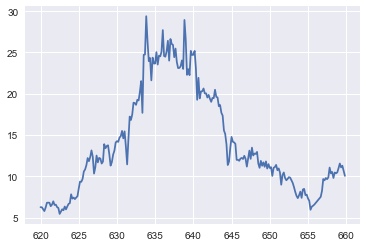

In [4]:
mk = (df.ds == 200210) & (df.z == 40) & (df.tt > 620) & (df.tt < 660)
plt.plot(df[mk].tt, df[mk].wind)

In [5]:
wind_temp_levels = df.pivot_table(
    values=['wind', 'temp'], columns='z', index=['ds', 'tt']
).reset_index()
wind_temp_levels.columns = [
    '%s_%d' % (a, b) if b else a
    for a, b in wind_temp_levels.columns.values
]

ddf = df.merge(wind_temp_levels, on=['ds', 'tt'])
ddf = ddf[(ddf.zL > -2) & (ddf.zL < 1)]

feats = [
    'air_dens', 'wind', 'temp', 'virtual_temp', 'z',
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux',
    'soilheat', 'netrad', 'temp_10', 'temp_20', 'temp_40', 'wind_10',
    'wind_20', 'wind_40'
]

ddf = ddf[feats + ['phi_m', 'ds', 'tt', 'zL', 'lval', 'H', 'LE', 'ustar']].dropna()

In [82]:
found = False
while not found:
    seed = np.random.randint(0, 2**31 - 1)
    np.random.seed(seed)
    test_months = np.random.choice(ddf.ds.unique(), 20, replace=False)
    found = 200210 in test_months
seed

61247877

In [81]:
np.random.seed(61247877)
test_months = np.random.choice(ddf.ds.unique(), 20, replace=False)
assert 200210 in test_months

# split train test
test_mask = ddf.ds.isin(test_months)
train_mask = ~test_mask
train_x, train_y = ddf[train_mask][feats], ddf[train_mask].phi_m
test_x, test_y = ddf[test_mask][feats], ddf[test_mask].phi_m

# normalize
mu_x, std_x = train_x.mean(), train_x.std()
mu_y, std_y = train_y.mean(), train_y.std()
train_x = (train_x - mu_x) / std_x
train_y = (train_y - mu_y) / std_y
val_x = val_y = None
test_x = (test_x - mu_x) / std_x
test_y = (test_y - mu_y) / std_y

# train model
res = fit_score({
    'n_estimators': 1000,
    'max_depth': 12,
    'min_child_weight': 10,
    'learning_rate': 0.04338746572092608,
    'reg_alpha': 1.698719697497604e-07,
    'reg_lambda': 5.955755313103155e-05,
    'loss': 'mae',
    'colsample_bytree': 0.12467084550095234,
    'subsample': 0.4931323091363833,
    'gamma': 0
}, save=False, get_predictions=True)

{'train_mse': 0.07288585376034067, 'train_denorm': 0.06185207229410053, 'val_mse': nan, 'val_denorm': nan, 'test_mse': 0.17562581683055317, 'test_denorm': 0.14903880737999411, 'params': {'n_estimators': 1000, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 0.04338746572092608, 'reg_alpha': 1.698719697497604e-07, 'reg_lambda': 5.955755313103155e-05, 'loss': 'mae', 'colsample_bytree': 0.12467084550095234, 'subsample': 0.4931323091363833, 'gamma': 0}, 'loss': nan, 'test_preds': array([1.2720835 , 0.6131188 , 0.82039285, ..., 0.6436394 , 0.9228288 ,
       0.33474898], dtype=float32)}


# cyclone

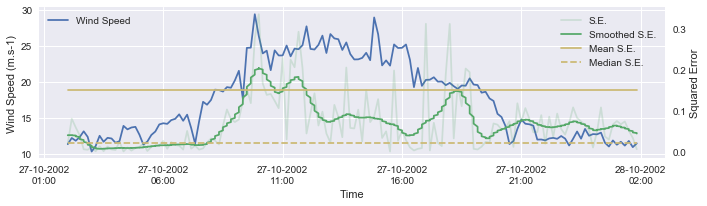

In [82]:
aa = ddf[test_mask].assign(
    sq_err=std_y**2 * (test_y - res['test_preds'])**2
)

cmk = (aa.ds == 200210) & (aa.tt > 626) & (aa.tt < 650)

mean_se, med_se = aa.sq_err.mean(), aa.sq_err.median()

fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()

ax.plot(aa[cmk & (aa.z == 40)].tt, aa[cmk & (aa.z == 40)].wind,
        color='C0', label='Wind Speed')
#ax2.plot(aa[cmk & (aa.z == 40)].tt, aa[cmk & (aa.z == 40)].zL, color='C1')

ax2.plot(aa[cmk].tt.unique(), aa[cmk].groupby('tt').sq_err.mean(),
         color='C1', label='S.E.', alpha=0.2)
ax2.plot(aa[cmk].tt, aa.sq_err.rolling(30, win_type='triang', center=True).mean()[cmk],
         color='C1', label='Smoothed S.E.')
xinterval = aa[cmk].tt.min(), aa[cmk].tt.max()
ax2.plot(xinterval, [mean_se, mean_se], 'C4', label='Mean S.E.')
ax2.plot(xinterval, [med_se, med_se], 'C4--', label='Median S.E.')


ticks, _ = plt.xticks()
datetimes = [
    datetime.datetime(
        day=1, month=10, year=2002
    ) + datetime.timedelta(
        hours=hr
    ) for hr in ticks
]

labels = ['%d-%d-%d\n%02d:%02d' % (
    row.day, row.month, row.year,
    row.hour, row.minute
) for row in datetimes]
plt.xticks(ticks[1:-1], labels[1:-1])

ax.set_ylabel('Wind Speed (m.s-1)')
#ax.set_ylim(0, 32)
ax.set_xlabel('Time')
ax2.set_ylabel('Squared Error')

plt.grid(False)
#plt.legend()
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('manuscript/images/jeanett_error.png')
plt.show()

# density plot

In [6]:
ss = ddf.sample(25000)
kde = stats.gaussian_kde(ss[['zL', 'phi_m']].T, 0.27)

In [7]:
pp2 = kde.logpdf(ss[['zL', 'phi_m']].T)

In [10]:
import bisect
sorted_log_probs = list(sorted(pp2))
point_percentile = [
    bisect.bisect(sorted_log_probs, p) / len(pp2)
    for p in pp2
]

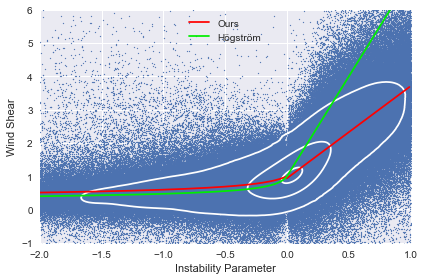

In [159]:
xx = np.arange(-2, 1, 0.01)
our_phim = [
    np.power(1 - 2.64**2 * zL, -0.25) if zL < 0 else (0.94 + 2.77 * zL)
    for zL in xx
]

hogs_phim = [
    np.power(1 - 19.3 * zL, -0.25) if zL < 0 else (1 + 6 * zL)
    for zL in xx
]

levels = [0.1, 0.5, 0.9]

plt.scatter(ddf.zL, ddf.phi_m, s=1, label='')
cs = plt.tricontour(ss.zL, ss.phi_m, point_percentile,
                    levels=levels, colors='#ffffff')
plt.plot(xx, our_phim, color='r', label='Ours')
plt.plot(xx, hogs_phim, color='#00ee00', label='Högström')
plt.legend(loc='upper center')
plt.xlim(-2, 1)
plt.ylim(-1, 6)
plt.xlabel('Instability Parameter')
plt.ylabel('Wind Shear')
plt.tight_layout()
plt.savefig('manuscript/images/most_zoom.png')

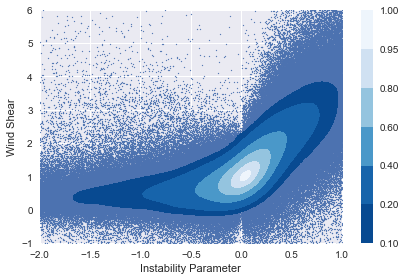

In [122]:
plt.scatter(ddf.zL, ddf.phi_m, s=1)

levels = [
    0.1, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0
]

cm = plt.get_cmap('Blues')
cs = plt.tricontourf(ss.zL, ss.phi_m, point_percentile, levels=levels,
                     colors=[cm(1 - l) for l in levels])
plt.xlim(-2, 1)
plt.ylim(-1, 6)
plt.colorbar()
plt.xlabel('Instability Parameter')
plt.ylabel('Wind Shear')
plt.savefig('manuscript/images/most_density.png')
plt.tight_layout()

In [381]:
pp = kde.logpdf(ps)

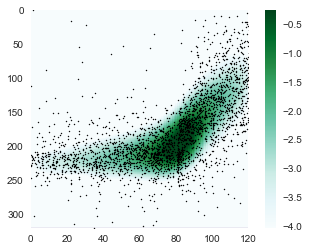

In [487]:
def rescale(data, vmin, vmax, dmin=None, dmax=None):
    dmin = data.min() if dmin is None else dmin
    dmax = data.max() if dmax is None else dmax
    
    data = (data - dmin) / (dmax - dmin)
    return data * (vmax - vmin) + vmin


plt.imshow(np.rot90(pp.T.reshape(len(xs), len(ys))),
           vmin=np.percentile(pp, 75),
           vmax=np.percentile(pp, 99),
           aspect=len(xs) / len(ys),
           cmap='BuGn')
plt.colorbar()


scatter_mask = -np.log(point_percentile) > 9 * np.random.random(size=len(point_percentile))
sdata = ss[scatter_mask]
plt.scatter(rescale(sdata.zL, 0, len(xs), xs.min(), xs.max()),
            rescale(sdata.phi_m, len(ys), 0, ys.min(), ys.max()),
            s=1.2, c='k')


plt.xlim(0, len(xs))
plt.ylim(len(ys), 0)
plt.grid(False)


#xts = plt.xticks()[0].astype(np.int)[1:-1]
#plt.xticks(xts, ['%.1f' % x for x in xs[xts]])

# mse by z/L

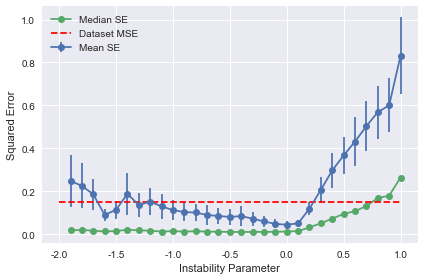

In [133]:
bins = np.arange(-2, 1, 0.1)
err_by_zL = aa.groupby(
    np.digitize(aa.zL, bins)
).sq_err.describe().assign(
    err=lambda df: df['std'] / 10
)

err_by_zL.plot(
    y='mean', color='C0', rot=0,
    label='Mean SE', yerr='err', marker='o',
)

err_by_zL['50%'].plot(
    color='C1', label='Median SE', marker='o'
)

mean_se = aa.sq_err.mean()
med_se = aa.sq_err.median()

plt.plot([0, 30], [mean_se, mean_se], 'r--', label='Dataset MSE')
plt.legend(loc='upper left')
ticks = range(0, 31, 5)
_ = plt.xticks(ticks, [t / 10 - 2 for t in ticks])
plt.xlabel('Instability Parameter')
plt.ylabel('Squared Error')
plt.tight_layout()
plt.savefig('manuscript/images/error_by_xi.png')